In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from skimage.feature import peak_local_max

%matplotlib inline

In [17]:
def laplacian_of_gaussian(sigma):
    kernel_radius = int(3 * sigma)  # Kernel radius based on sigma
    x_coords, y_coords = np.meshgrid(np.arange(-kernel_radius, kernel_radius + 1), np.arange(-kernel_radius, kernel_radius + 1))

    squared_distances = (x_coords**2 + y_coords**2) / (2 * sigma**2)
    gaussian_term = np.exp(-squared_distances)
    laplacian_term = (squared_distances - 1)

    log_kernel = laplacian_term * gaussian_term / (np.pi * sigma**4)
    return log_kernel


In [18]:
def find_local_maxima(log_image, sigma):
    maxima_coords = []
    height, width = log_image.shape
    offset = 1

    for row in range(offset, height - offset):
        for col in range(offset, width - offset):
            local_patch = log_image[row - offset:row + offset + 1, col - offset:col + offset + 1]
            max_value = np.max(local_patch)  # Find the local maximum

            if max_value >= 0.09:  # Threshold check
                local_max_row, local_max_col = np.unravel_index(np.argmax(local_patch), local_patch.shape)
                maxima_coords.append((row + local_max_row - offset, col + local_max_col - offset))

    return set(maxima_coords)


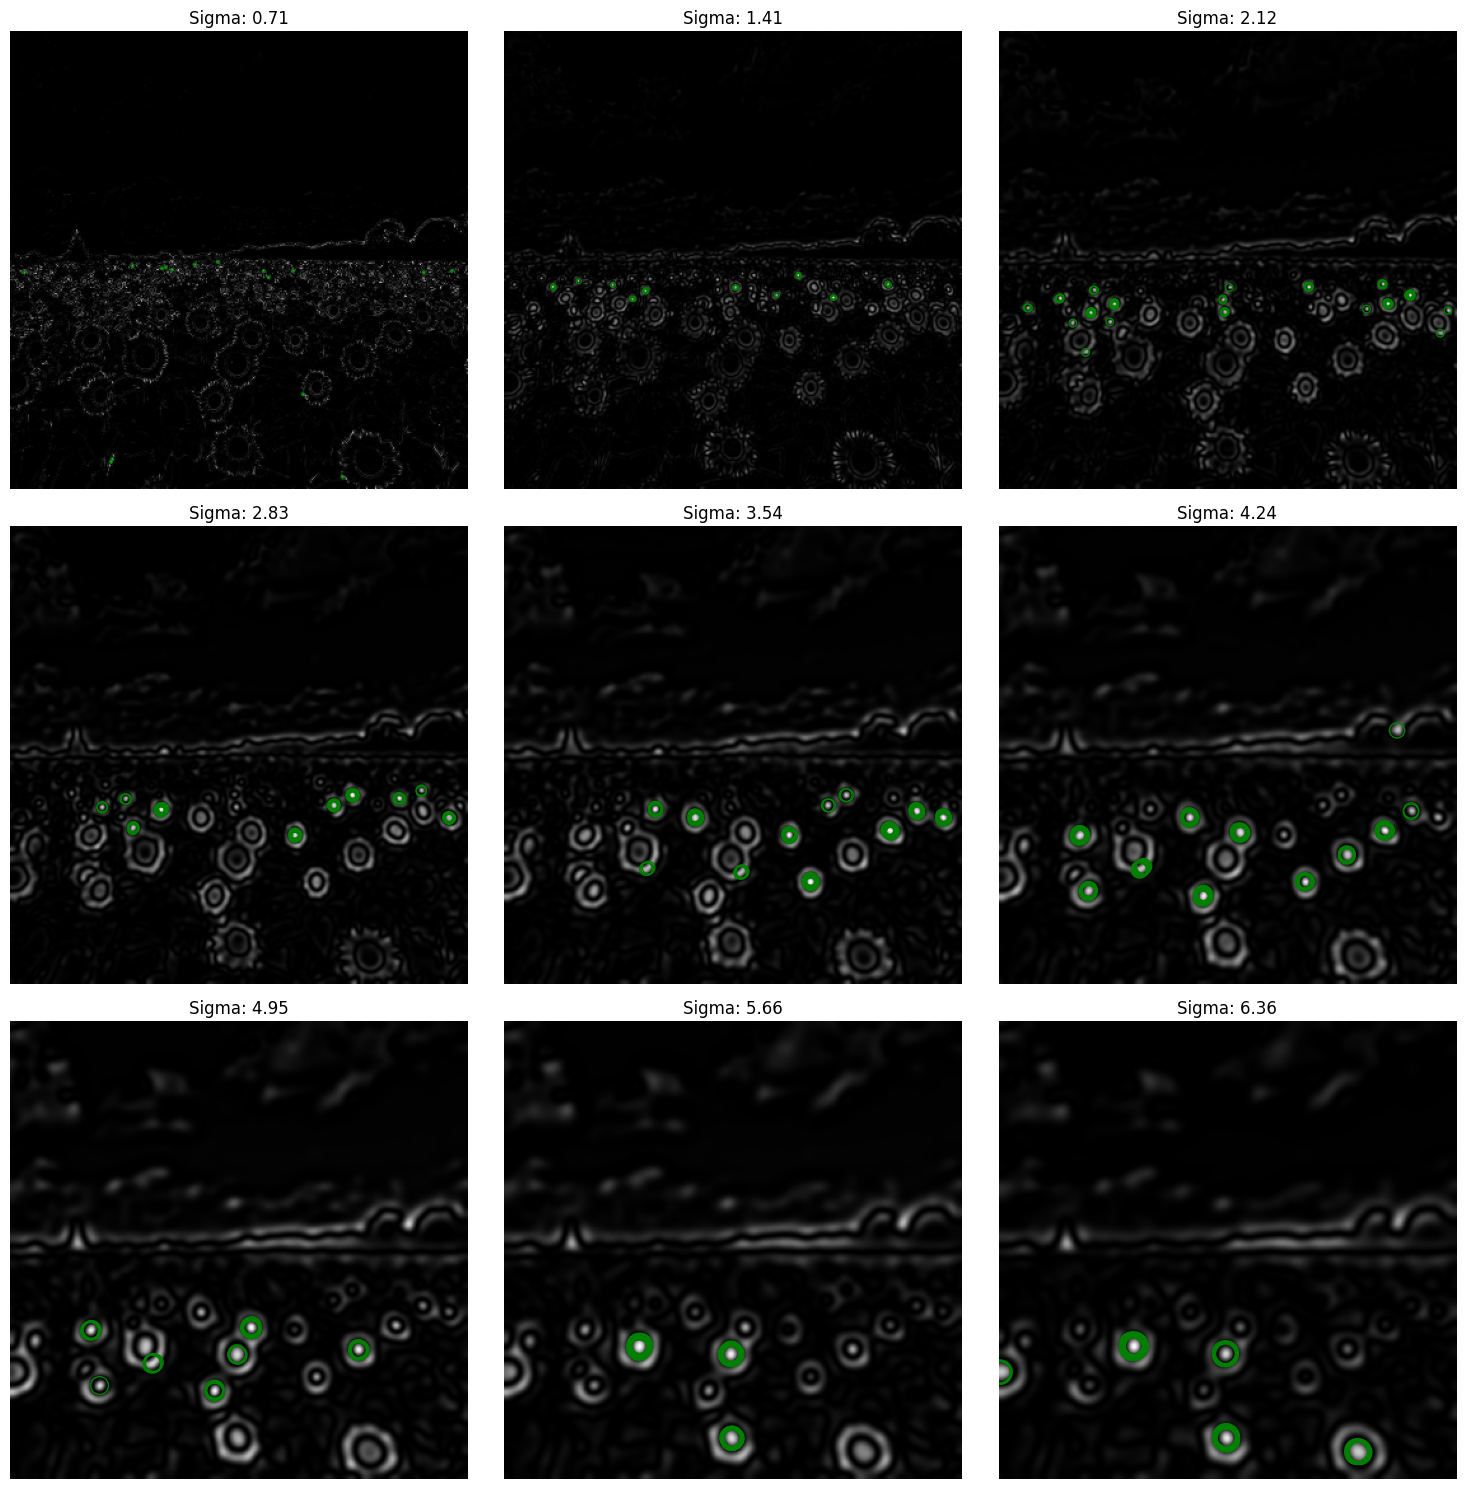

In [20]:
# Load and preprocess the image
image = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
grayscale_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) / 255

# Set up the figure for displaying the results
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Loop over different sigma values to find local peaks
for index, axis in enumerate(axes.flatten(), start=1):
    sigma = index / 1.414
    log_kernel = laplacian_of_gaussian(sigma) * sigma**2  # LoG kernel
    log_filtered = np.square(cv.filter2D(grayscale_image, -1, log_kernel))  # Apply LoG filter

    # Find local maxima (coordinates of detected blobs)
    maxima_coordinates = find_local_maxima(log_filtered, sigma)

    # Display the LoG-filtered image
    axis.imshow(log_filtered, cmap='gray')
    axis.set_title(f'Sigma: {sigma:.2f}')

    # Mark detected blobs with circles
    for x, y in maxima_coordinates:
        circle = plt.Circle((y, x), sigma * 1.414, color='green', linewidth=1, fill=False)
        axis.add_patch(circle)
    
    axis.axis('off')  # Turn off axis for better visualization

# Show the figure with all subplots
plt.tight_layout()
plt.show()

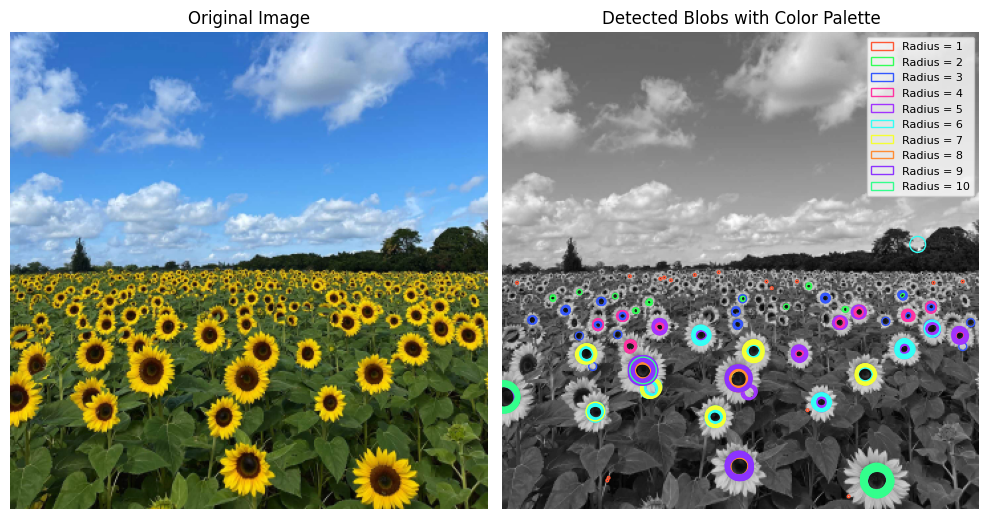

In [21]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the image and preprocess it
image = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
grayscale_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) / 255

# Set up the figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

# Show the original image in the first subplot
axes[0].imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
axes[0].set_title("Original Image")
axes[0].axis('off')

# Initialize the second subplot
ax = axes[1]
ax.imshow(grayscale_image, cmap='gray')
ax.grid(False)

# Define a new color palette for circles
colors = ['#FF5733', '#33FF57', '#3357FF', '#FF33A1', '#A133FF', '#33FFF5', '#F5FF33', '#FF8C33', '#8C33FF', '#33FF8C']

# Initialize lists for patches and labels
patches = []
labels = []

# Loop over different radius values to detect blobs
for radius in range(1, 11):
    sigma = radius / 1.414
    log_kernel = sigma**2 * laplacian_of_gaussian(sigma)  # Create LoG kernel
    log_filtered = np.square(cv.filter2D(grayscale_image, -1, log_kernel))  # Apply LoG filter

    # Detect maxima (blobs) using the sigma value
    blob_coordinates = find_local_maxima(log_filtered, sigma)

    # Plot detected blobs as circles in different colors
    for x, y in blob_coordinates:
        circle = plt.Circle((y, x), sigma * 1.414, color=colors[radius - 1], linewidth=1, fill=False)
        ax.add_patch(circle)
    
    # Add the current circle as a patch and store label
    patches.append(circle)
    labels.append(f'Radius = {radius}')

# Set limits for x-axis and hide axis in the second subplot
ax.set_xlim(0, image.shape[1])
ax.set_title("Detected Blobs with Color Palette")
ax.legend(patches, labels, loc='best', fontsize=8)

# Remove axis for a cleaner display
ax.axis('off')

# Show the final plot
plt.tight_layout()
plt.show()


<Axes: >

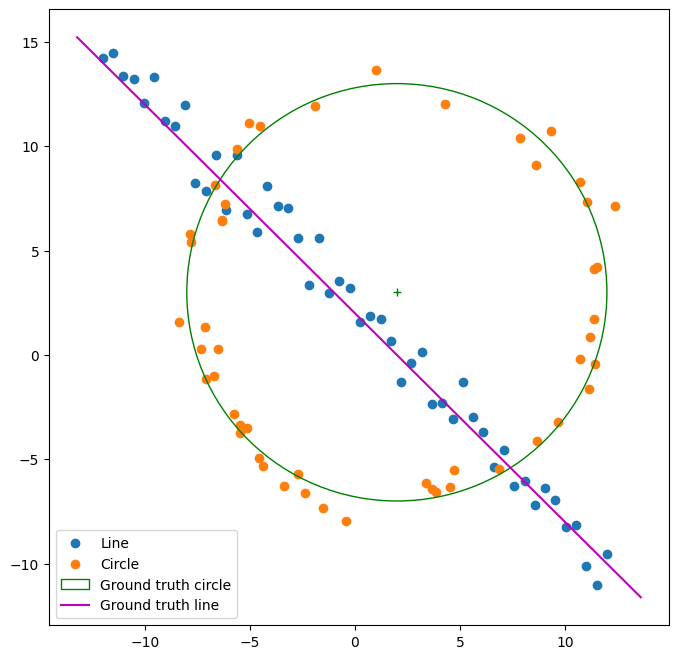

In [24]:
# Generating noisy point set

from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import numpy as np
# import tikzplotlib

# Set random seed
np.random.seed(0)

# Constants
N = 100
half_n = N // 2

# Parameters
r = 10
x0_gt, y0_gt = 2, 3
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

s, m, b = 1, -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))

# Plotting
def plot_all(separate = True):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    if separate:
        ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
        ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')
    else:
        ax.scatter(X[:, 0], X[:, 1], label='Point Set')

    circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
    ax.add_patch(circle_gt)
    ax.plot(x0_gt, y0_gt, '+', color='g')

    x_min, x_max = ax.get_xlim()
    x_ = np.array([x_min, x_max])
    y_ = m * x_ + b
    plt.plot(x_, y_, color='m', label='Ground truth line')

    plt.legend()
    return ax

plot_all()

In [31]:
def dist(p1, p2):
    (x1, y1), (x2, y2) = p1, p2
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5

def line_eq(p1, p2):
    (x1, y1), (x2, y2) = p1, p2
    a = (y2 - y1)
    b = -(x2 - x1)
    d = a*x1 + b*y1
    assert abs(a*x2 + b*y2 - d) < 1e-8

    # Apply constraint
    norm = (a**2 + b**2)**0.5
    a, b, d = a/norm, b/norm, d/norm
    return a, b, d

def circle_eq(p1, p2, p3):
    (x1, y1), (x2, y2), (x3, y3) = p1, p2, p3
    
    # circumcenter of circle is equidistant to all points
    mx1, my1 = (x1 + x2)/2, (y1 + y2)/2
    mx2, my2 = (x1 + x3)/2, (y1 + y3)/2

    s1 = -(x2 - x1)/(y2 - y1)
    s2 = -(x3 - x1)/(y3 - y1)

    c1 = my1 - s1 * mx1
    c2 = my2 - s2 * mx2

    cx = (c2 - c1)/(s1 - s2)
    cy = s1 * cx + c1
    assert abs(s2 * cx + c2 - cy) < 1e-8

    r = dist((cx, cy), p1)
    assert abs(dist((cx, cy), p2) - dist((cx, cy), p1)) < 1e-8
    return cx, cy, r

In [32]:
# Squared error calculation for line and circle
def tls_error_line(params, *args):
    # Error of points denoted by indices, params is the one that should be optimized
    a, b, d = params
    indices, X = args
    error = np.sum((a * X[indices, 0] + b * X[indices, 1] - d)**2)
    return error

def tls_error_circle(params, *args):
    cx, cy, r = params
    indices, X = args
    error = np.sum((dist((cx, cy), (X[indices, 0], X[indices, 1])) - r)**2)
    return error

In [33]:
def consensus_line(params, thres, X):   # Whether each point is an inlier
    a, b, d = params
    errors = np.abs(a * X[:, 0] + b * X[:, 1] - d)
    return np.where(errors < thres)

def consensus_circle(params, thres, X):   # Whether each point is an inlier
    cx, cy, r = params
    errors = np.abs(dist((cx, cy), (X[:, 0], X[:, 1])) - r) # radial error
    return np.where(errors < thres)

def constraint(params): # Should be equal to zero
    a, b, d = params
    return (a**2 + b**2)**0.5 - 1

constraint_dict = {'type':'eq', 'fun':constraint}

def least_squares_line_fit(indices, initial, X):  # line fitting with scipy minimize
    res = minimize(fun=tls_error_line, x0=initial, args=(indices, X), constraints=constraint_dict, tol=1e-6)
    print(res.x, res.fun)
    return res

def least_squares_circ_fit(indices, initial, X):
    res = minimize(fun=tls_error_circle, x0=initial, args=(indices, X), tol=1e-6)
    print(res.x, res.fun)
    return res

In [34]:
# Fitting the line

iters = 100
min_points = 2
N = X.shape[0]
np.random.seed(14)

thres = 1.   # Error threshold for selecting inliers
d = 0.4 * N # Minimum inlier count for a good fit

best_model_line = None
best_fitted_line = None
best_error = np.inf
best_line_inliers = None
best_line_sample_points = None

for i in range(iters):
    indices = np.random.choice(np.arange(0, N), size=min_points, replace=False)
    params = line_eq(X[indices[0]], X[indices[1]])
    inliers = consensus_line(params, thres, X)[0]
    print(f'Iteration {i}: No. of inliers = {len(inliers)}')

    if len(inliers) >= d:   # compute again 
        res = least_squares_line_fit(inliers, params, X)
        if res.fun < best_error:
            best_error = res.fun
            best_model_line = params
            best_fitted_line = res.x
            best_line_inliers = inliers
            best_sample_points = indices

line_inliers = consensus_line(best_fitted_line, 1.2, X)[0]

print(f'Best line = {best_fitted_line}, No. of inliers = {len(line_inliers)}, best_error = {best_error}')
    

Iteration 0: No. of inliers = 9
Iteration 1: No. of inliers = 34
Iteration 2: No. of inliers = 4
Iteration 3: No. of inliers = 16
Iteration 4: No. of inliers = 6
Iteration 5: No. of inliers = 12
Iteration 6: No. of inliers = 11
Iteration 7: No. of inliers = 8
Iteration 8: No. of inliers = 12
Iteration 9: No. of inliers = 15
Iteration 10: No. of inliers = 5
Iteration 11: No. of inliers = 8
Iteration 12: No. of inliers = 37
Iteration 13: No. of inliers = 12
Iteration 14: No. of inliers = 21
Iteration 15: No. of inliers = 8
Iteration 16: No. of inliers = 10
Iteration 17: No. of inliers = 16
Iteration 18: No. of inliers = 12
Iteration 19: No. of inliers = 23
Iteration 20: No. of inliers = 29
Iteration 21: No. of inliers = 6
Iteration 22: No. of inliers = 39
Iteration 23: No. of inliers = 38
Iteration 24: No. of inliers = 10
Iteration 25: No. of inliers = 4
Iteration 26: No. of inliers = 22
Iteration 27: No. of inliers = 40
[0.71205467 0.70212402 1.53281698] 8.09865025050975
Iteration 28: N

In [35]:
# fitting the circle

remaining_points = np.array([i for i in range(N) if i not in line_inliers])
X_rem = X[remaining_points]

iters = 100
min_points = 3  # We need 3 points to estimate a circle

thres = 1.2   # Error threshold for selecting inliers
d = 0.4 * N # Minimum inlier count for a good fit

best_model_circle = None
best_fitted_circle = None
best_error = np.inf
best_circ_inliers = None
best_circ_sample_points = None

for i in range(iters):
    indices = np.random.choice(np.arange(len(X_rem)), size=min_points, replace=False)
    params = circle_eq(*X_rem[indices])
    inliers = consensus_circle(params, thres, X_rem)[0]
    print(f'Iteration {i}: No. of inliers = {len(inliers)}')

    if len(inliers) >= d:   # compute again 
        res = least_squares_circ_fit(inliers, params, X_rem)
        if res.fun < best_error:
            best_error = res.fun
            best_model_circle = params
            best_fitted_circle = res.x
            best_circ_inliers = inliers
            best_circ_sample_points = indices

circ_inliers = consensus_circle(best_fitted_circle, thres, X_rem)[0]

print(f'Best circle = {best_fitted_circle}, No. of inliers = {len(circ_inliers)}, best_error = {best_error}')

Iteration 0: No. of inliers = 10
Iteration 1: No. of inliers = 12
Iteration 2: No. of inliers = 10
Iteration 3: No. of inliers = 41
[1.8828232  3.18299016 9.81978826] 8.709305494445344
Iteration 4: No. of inliers = 34
Iteration 5: No. of inliers = 5
Iteration 6: No. of inliers = 25
Iteration 7: No. of inliers = 21
Iteration 8: No. of inliers = 30
Iteration 9: No. of inliers = 41
[1.69665199 3.00402845 9.92790141] 9.203751651287867
Iteration 10: No. of inliers = 37
Iteration 11: No. of inliers = 17
Iteration 12: No. of inliers = 25
Iteration 13: No. of inliers = 35
Iteration 14: No. of inliers = 11
Iteration 15: No. of inliers = 44
[1.81818057 3.07505684 9.97826825] 12.835201704007074
Iteration 16: No. of inliers = 8
Iteration 17: No. of inliers = 18
Iteration 18: No. of inliers = 39
Iteration 19: No. of inliers = 28
Iteration 20: No. of inliers = 14
Iteration 21: No. of inliers = 10
Iteration 22: No. of inliers = 34
Iteration 23: No. of inliers = 28
Iteration 24: No. of inliers = 41
[1

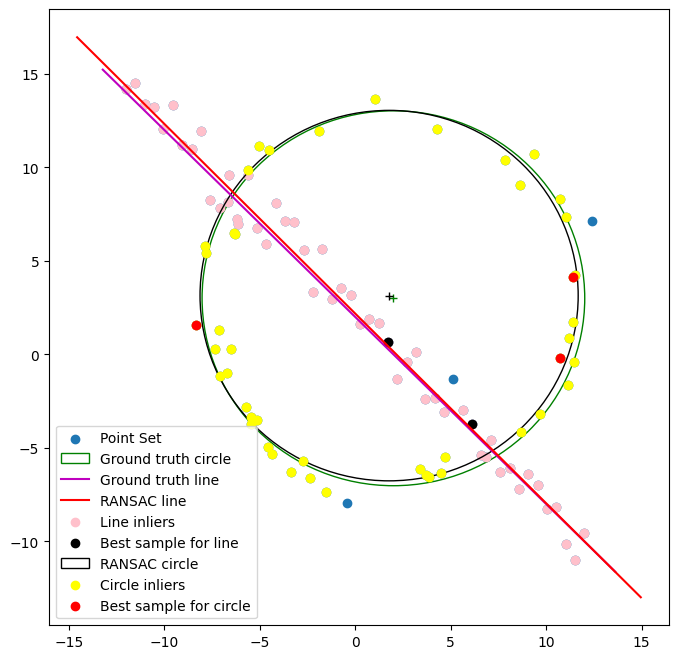

In [36]:
ax = plot_all(False)

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
A, B, D = best_fitted_line
indices = line_inliers

y_ = (D - A*x_) / B
plt.plot(x_, y_, color='r', label='RANSAC line')
ax.scatter(X[indices, 0], X[indices, 1], color = 'pink', label = "Line inliers")
ax.scatter(X[best_sample_points, 0], X[best_sample_points, 1], color = 'black', label = "Best sample for line")

x0, y0, r0 = best_fitted_circle
circle_gt = plt.Circle((x0, y0), r0, color='black', fill=False, label='RANSAC circle')
ax.add_patch(circle_gt)
ax.plot(x0, y0, '+', color='black')

ax.scatter(X_rem[circ_inliers, 0], X_rem[circ_inliers, 1], color = 'yellow', label = "Circle inliers")
ax.scatter(X_rem[best_circ_sample_points, 0], X_rem[best_circ_sample_points, 1], color = 'red', label = "Best sample for circle")

plt.legend()